# Clustering Centers and Scores
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script calcules the clusters centers and respective scores according to different simillarity measures:
- Euclidean
- DTW
- kMedoids-DTW

In [1]:
from dtaidistance.dtw_barycenter import dba_loop as dba_centre
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from tslearn.barycenters import euclidean_barycenter as euc_center

from dtaidistance.ed import distance as euc_dist
from dtaidistance.dtw import distance_fast as dtw_dist
from sktime.clustering.k_medoids import TimeSeriesKMedoids

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import time
from tqdm.auto import tqdm
import os
from itertools import cycle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [3]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
solution_name = 'FC_N2D-sage_sweep_1_v90'

In [4]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

sol_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{solution_name}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

---
# Data Imports

In [5]:
df_data = pl.read_csv(dataset_location)

---
# Ploting Functions

In [6]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [43]:
def plot_elbow(df_centers, alg = 'kMeans', mode = 'Total_Score', line_type = 'avg'):
    
    df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Average'
        
    elif line_type == 'w_avg':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['Cluster_Size', 'k', mode]].groupby('k').apply(w_avg, mode, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: mode}, inplace=True)    
        line_name = 'Weighted Average'
    
    elif line_type == 'sum':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Total Sum'
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[mode],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(93, 164, 214, 0.5)',
            marker_size=3,
            line_width=1.5,
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[mode],
            mode = 'lines+markers',
            name = line_name,
            marker_color='rgba(128, 0, 0, .6)'
        )
    )
        
    # fig.update_layout(
    #     margin=dict(l=20, r=20, t=20, b=20),
    #     template="seaborn",
    #     showlegend = False
    # )
    # Figure Style
    sol_name = solution_name.split('-')[0]
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': f'<b>{sol_name} {alg}</b> - Var: {mode}',
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    
    fig.show()

In [8]:
def plot_cluster_samples (df_centers, df_data, mode = 'Total_Score', alg = 'kMeans', k = 'k10', cluster = 1, sample = 10, seed = 42):
    
    df_center = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k) & (df_centers['cluster'] == cluster)]
    center = df_center[window_cols].values.ravel()
    
    sol = ('_').join([alg, k])    
    df_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == cluster).select(["short_ID", "window_ID"]).collect().sample(n=sample, seed=seed)  
    df_samples = df_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
    samples = df_samples[window_cols].values
    
    fig = go.Figure()
       
    # Samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(
                x = window_cols,
                y = sample,
                mode = 'lines',
                name = 'Average',
                marker_color='rgba(36, 37, 42, .25)',
                hoverinfo='skip'
            )
        )    
        
    # Center Line
    fig.add_trace(
        go.Scatter(
            x = window_cols,
            y = center,
            mode = 'lines',
            name = 'Cluster Center',
            line=dict(color='rgba(217, 30, 24, .8)', width=3.5),
            hovertemplate='%{y:.2f}',
        )
    )
 
    
    # Figure Style
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': f'<b>Cluster: {cluster}</b> - {alg}_{k}',
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [9]:
def plot_centers(df_centers, alg = 'kMeans', k = 'k10'):
    
    df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}'
            )
        )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = True 
    )


    fig.show()
    

In [10]:
def plot_flow(df_data, alg = 'kMeans', k = 'k10', sample = 1000, groupnorm = 'percent'):
    
    sol = ('_').join([alg, k])   
    if sample == 'all':
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).collect()
    else:
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).fetch(sample)  
        
    df = df_ids.join(df_data[['short_ID', 'window_ID', 'window_start_date']], on = ['short_ID', 'window_ID'], how='left').to_pandas()
    df = df[['short_ID', 'window_ID', 'window_start_date', sol]]

    df['window_start_date'] = pd.to_datetime(df['window_start_date'])   
    df = df.set_index('window_start_date').groupby('short_ID').resample('1D').mean().reset_index(level='short_ID', drop=True).astype('Int64', errors = 'ignore').reset_index().fillna(method='ffill')
    
    cmin = df[sol].min()
    cmax = df[sol].max()
    
    palette = cycle(px.colors.qualitative.T10)
    fig = go.Figure()
    for c in range(cmin, cmax+1):
        cluster_count = df[df[sol]==c].groupby('window_start_date')[sol].count()
    
        fig.add_trace(
            go.Scatter(
                x=cluster_count.index,
                y=cluster_count.values,
                fill='tonexty',
                mode= 'lines',
                name = f'Cluster: {c}',
                stackgroup = 'one',
                groupnorm=groupnorm,
                hovertemplate='%{y:.1f}',
                line=dict(width=0, color=next(palette))
            )
        )
        
    # Figure Style
    sol_name = solution_name.split('-')[0]
    if groupnorm == 'percent':
        graph_mode = 'Percentage'
    else:
        graph_mode = 'Total Count'
        
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="plotly_white",
        showlegend = True,
        legend = {
            'y': 0.5,
            'yanchor': 'middle',
        },
        hovermode = 'x',
        title={
            'text': f'{graph_mode}: <b>{sol_name} {alg} (k={k[1:]})</b>',
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )

    fig.show()

---
# Flow Charts

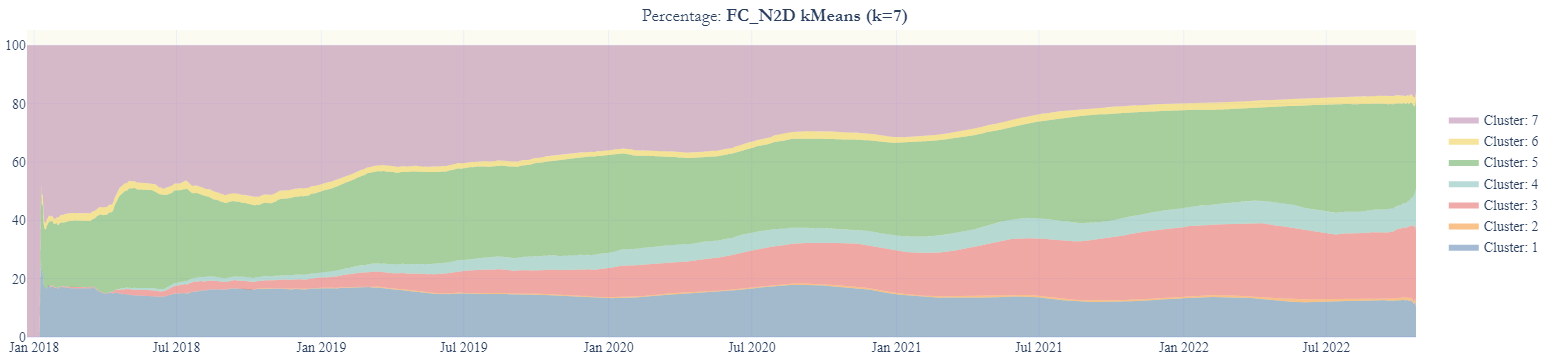

In [11]:
plot_flow(df_data, alg = 'kMeans', k='k7', groupnorm = 'percent', sample = 'all')

In [12]:
plot_flow(df_data, alg = 'kMeans', k='k7', groupnorm = None, sample = 'all')

---
# Gini Index
see <code>Exploration_Gini</code> notebook

In [11]:
def gini_index (x):
    # https://en.wikipedia.org/wiki/Gini_coefficient#cite_note-23
    # Alternative expressions
    
    # x must be 1-d array of distances
    x = np.float64(x)
    # x is sorted in the function
    x = np.sort(x)
    sum_x = x.cumsum()[-1]
    
    ix = x * np.arange(1, len(x)+1)
    sum_ix = ix.cumsum()[-1]

    n = len(x)
        
    total = ((2 * sum_ix) / (n * sum_x)) - (n+1)/n
        
    return total

---
# Euclidean
https://dtaidistance.readthedocs.io/en/latest/usage/ed.html  
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.euclidean_barycenter.html#tslearn.barycenters.euclidean_barycenter  

In [39]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
algorithms = []
k = []
clusters = []
avg_scores = []
cum_p95 = []
cum_p99 = []
# gini = []
median = []
p95 = []
p99 = []
# qsc = []
qcd = []
# skew_median = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre
        centroid = euc_center(sol_data).ravel()
        # Saving cluster centre
        centroids.append(centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = euc_dist(centroid, window)
            scores.append(score)
        scores = np.abs(scores)
        total_scores.append(np.sum(scores))
        avg_scores.append(np.mean(scores))
        
        cum_p95.append(np.sum(np.where(scores <= np.percentile(scores, 95), scores, 0)))
        cum_p99.append(np.sum(np.where(scores <= np.percentile(scores, 99), scores, 0)))
        # gini.append(gini_index(scores))

        # p50.append(np.percentile(scores, 50))
        # p95.append(np.percentile(scores, 95))
        # p99.append(np.percentile(scores, 99))
        # q1, q2, q3 = np.percentile(scores, [25, 50, 75])
        q1, q2, q3, p95_, p99_ = np.percentile(scores, [25, 50, 75, 95, 99])
        median.append(q2)
        p95.append(p95_)
        p99.append(p99_)
        # if q3 - q1 == 0:
        #     qsc.append(0)
        # else:
        #     qsc.append((q3 + q1 - 2*q2) / (q3 - q1))
        qcd.append((q3 - q1) / (q3 + q1)) # Quartile Coefficient of Dispersion
                
        # skew_median.append(3*(np.mean(scores) - np.median(scores)) / np.std(scores))
        
        
Euclidean_centres = pd.DataFrame(centroids, columns=window_cols)
Euclidean_centres.insert(0, "cluster", clusters)
Euclidean_centres.insert(0, "k", k)
Euclidean_centres.insert(0, "Algorithm", algorithms)
Euclidean_centres.insert(3, "Mean", avg_scores)
Euclidean_centres.insert(3, "Median", median)
Euclidean_centres.insert(3, "p95", p95)
Euclidean_centres.insert(3, "p99", p99)
Euclidean_centres.insert(3, "QCD", qcd)
# Euclidean_centres.insert(3, "QSC", qsc)
# Euclidean_centres.insert(3, "Skew", skew_median)
Euclidean_centres.insert(3, "Sum_p95", cum_p95)
Euclidean_centres.insert(3, "Sum_p99", cum_p99)
# Euclidean_centres.insert(3, "Gini", gini)
Euclidean_centres.insert(3, "Total_Score", total_scores)
Euclidean_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

In [40]:
Euclidean_centres.iloc[:,:12].tail(9)

Algorithm    k  cluster  Cluster_Size    Total_Score        Sum_p99  \
639     KUMAP  k25       17         38202  157293.111553  155257.556287   
640     KUMAP  k25       18         27222  101469.444586   99365.132489   
641     KUMAP  k25       19           168      55.106667      39.965679   
642     KUMAP  k25       20         33858  133642.443820  131830.112838   
643     KUMAP  k25       21           262       0.281923       0.132053   
644     KUMAP  k25       22           176      92.014838      76.702486   
645     KUMAP  k25       23           169      65.319282      50.263669   
646     KUMAP  k25       24           595       7.717297       6.692649   
647     KUMAP  k25       25         38129  148172.513087  145996.947944   

           Sum_p95       QCD       p99       p95    Median      Mean  
639  147720.227435  0.066294  5.090566  4.832647  4.099190  4.117405  
640   94378.504921  0.066910  5.015867  4.353793  3.688899  3.727479  
641      28.500443  0.000000  7.561669  0.586224  0.155945  0.328016  
642  125208.630870  0.084418  5.079173  4.768860  3.941230  3.947145  
643       0.107457  0.000000  0.015105  0.000420  0.000420  0.001076  
644      54.167629  0.000000  7.441373  1.366818  0.251409  0.522812  
645      30.169818  0.000000  7.268068  0.569029  0.180128  0.386505  
646       5.334914  0.565647  0.128285  0.022554  0.009490  0.012970  
647  138623.227496  0.098078  5.093438  4.706248  3.914269  3.886084

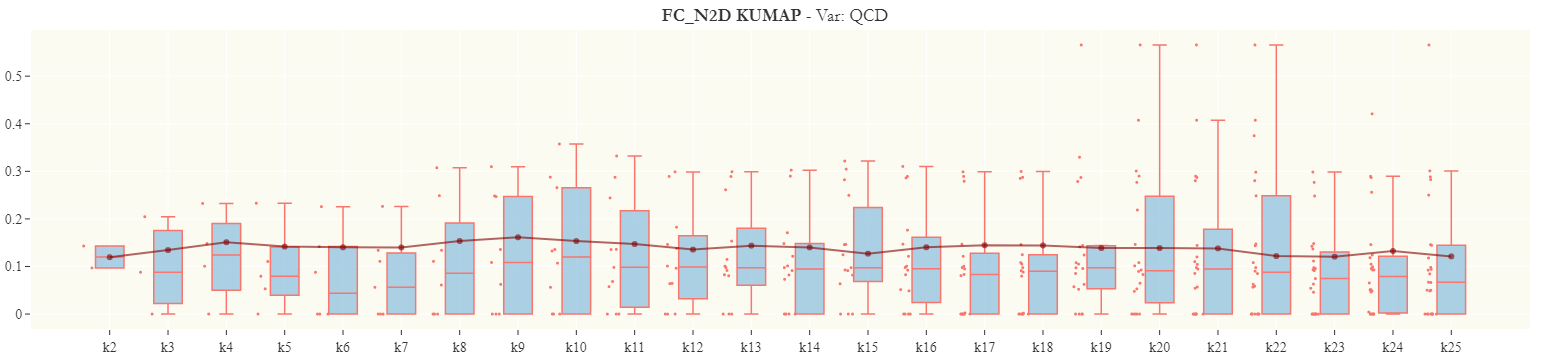

In [46]:
plot_elbow(Euclidean_centres, alg='KUMAP', mode = 'QCD', line_type='w_avg')

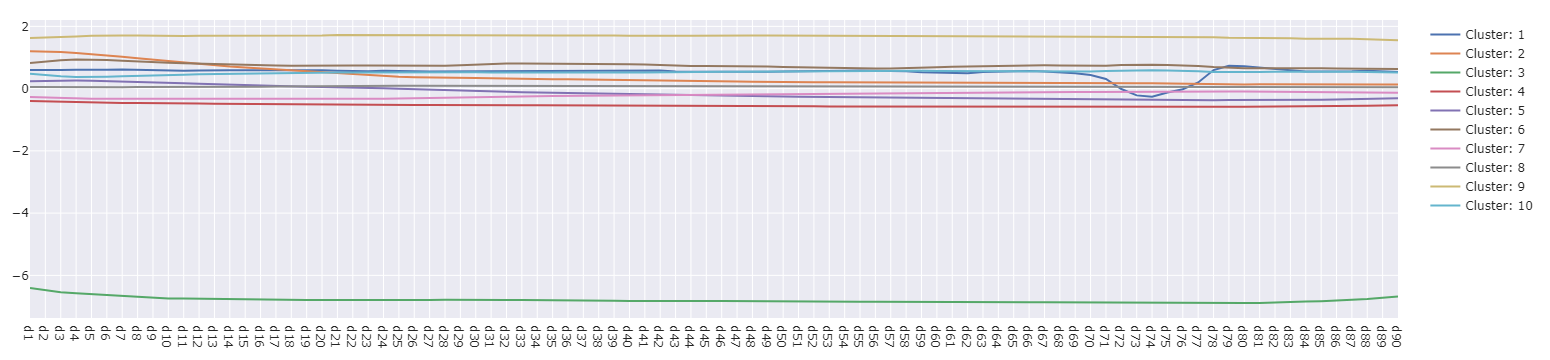

In [14]:
plot_centers(Euclidean_centres, alg='kMeans', k = 'k10')

In [15]:
('_').join(['kMeans', 'k10'])  

'kMeans_k10'

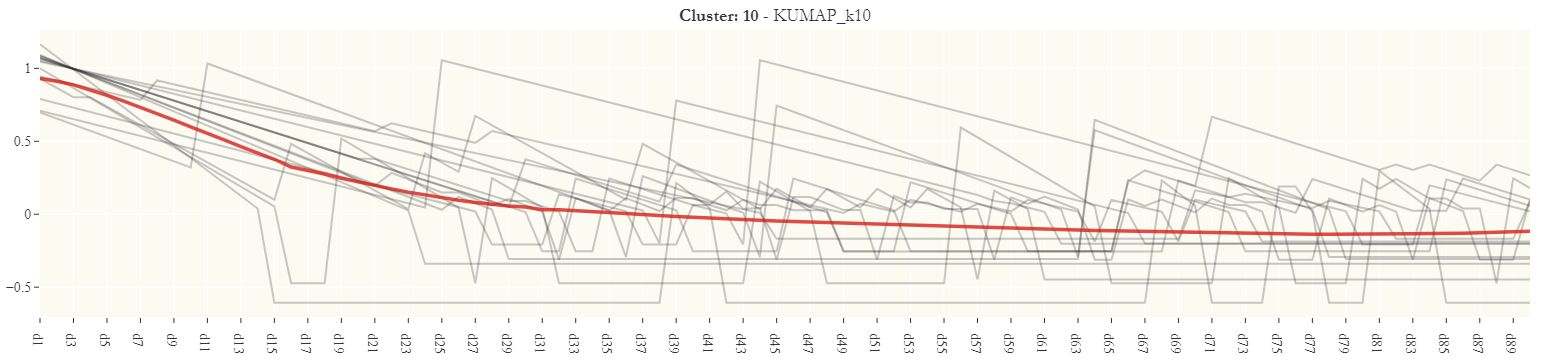

In [16]:
plot_cluster_samples(Euclidean_centres, df_data, alg = 'KUMAP', k = 'k10', cluster=10, sample=15, seed=42)

---
# DTW & *"kMedoid"*
https://dtaidistance.readthedocs.io/en/latest/modules/dtw_barycenter.html  
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [47]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
algorithms = []
k = []
clusters = []
n_w_cluster = []

dba_centroids = []
dtw_avg_scores = []
dtw_total_scores = []
dtw_cum_p95 = []
dtw_cum_p99 = []
# dtw_gini = []
dtw_median = []
dtw_p95 = []
dtw_p99 = []
# dtw_qsc = []
dtw_qcd = []

dtai_kmedoids = []
kmedoid_total_scores = []
kmedoid_avg_scores = []
kmedoid_cum_p95 = []
kmedoid_cum_p99 = []
# kmedoid_gini = []
kmedoid_median = []
kmedoid_p95 = []
kmedoid_p99 = []
# kmedoid_qsc = []
kmedoid_qcd = []

i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) 

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))
        
        # Calculating DTW cluster centre
        dba_centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
        # Saving DTW cluster centre
        dba_centroids.append(dba_centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for DTW
        dtw_scores = []
        for window in sol_data:
            dtw_score = dtw_dist(dba_centroid, window)
            dtw_scores.append(dtw_score)
        dtw_total_scores.append(np.sum(np.abs(dtw_scores)))
        dtw_avg_scores.append(np.mean(np.abs(dtw_scores)))
        
        dtw_cum_p95.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 95), dtw_scores, 0)))
        dtw_cum_p99.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 99), dtw_scores, 0)))
        # dtw_gini.append(gini_index(dtw_scores))
        
        q1, q2, q3, p95_, p99_ = np.percentile(dtw_scores, [25, 50, 75, 95, 99])
        dtw_median.append(q2)
        dtw_p95.append(p95_)
        dtw_p99.append(p99_)
        dtw_qcd.append((q3 - q1) / (q3 + q1)) # Quartile Coefficient of Dispersion

        # q1, q2, q3 = np.percentile(dtw_scores, [25, 50, 75])
        # if q3 - q1 == 0:
        #     dtw_qsc.append(0)
        # else:
        #     dtw_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))

        
        
        # Identifying kMedoid
        idx_min = np.argmin(np.abs(dtw_scores))
        dtai_kmedoid = sol_data[idx_min]
        dtai_kmedoids.append(dtai_kmedoid)
        
        # Calculating Average Score for kMedoid (DTW)
        kmedoid_scores = []
        for window in sol_data:
            kmedoid_score = dtw_dist(dtai_kmedoid, window)
            kmedoid_scores.append(kmedoid_score)
        kmedoid_total_scores.append(np.sum(np.abs(kmedoid_scores)))
        kmedoid_avg_scores.append(np.mean(np.abs(kmedoid_scores)))
        
        kmedoid_cum_p95.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 95), kmedoid_scores, 0)))
        kmedoid_cum_p99.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 99), kmedoid_scores, 0)))
        # kmedoid_gini.append(gini_index(kmedoid_scores))        
        
        q1, q2, q3, p95_, p99_ = np.percentile(kmedoid_scores, [25, 50, 75, 95, 99])
        kmedoid_median.append(q2)
        kmedoid_p95.append(p95_)
        kmedoid_p99.append(p99_)
        kmedoid_qcd.append((q3 - q1) / (q3 + q1)) # Quartile Coefficient of Dispersion

        # kmedoid_p95.append(np.percentile(kmedoid_scores, 95))
        # kmedoid_p99.append(np.percentile(kmedoid_scores, 99))
        # q1, q2, q3 = np.percentile(kmedoid_scores, [25, 50, 75])
        # if q3 - q1 == 0:
        #     kmedoid_qsc.append(0)
        # else:
        #     kmedoid_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))




DTW_centres = pd.DataFrame(dba_centroids, columns=window_cols)
DTW_centres.insert(0, "cluster", clusters)
DTW_centres.insert(0, "k", k)
DTW_centres.insert(0, "Algorithm", algorithms)
DTW_centres.insert(3, "Mean", dtw_avg_scores)
DTW_centres.insert(3, "Median", dtw_median)
DTW_centres.insert(3, "p95", dtw_p95)
DTW_centres.insert(3, "p99", dtw_p99)
DTW_centres.insert(3, "QCD", dtw_qcd)
# DTW_centres.insert(3, "QSC", dtw_qsc)
DTW_centres.insert(3, "Sum_p95", dtw_cum_p95)
DTW_centres.insert(3, "Sum_p99", dtw_cum_p99)
# DTW_centres.insert(3, "Gini", dtw_gini)
DTW_centres.insert(3, "Total_Score", dtw_total_scores)
DTW_centres.insert(3, "Cluster_Size", n_w_cluster)

        
DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
DTAI_kMedoids_centres.insert(0, "cluster", clusters)
DTAI_kMedoids_centres.insert(0, "k", k)
DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
DTAI_kMedoids_centres.insert(3, "Mean", kmedoid_avg_scores)
DTAI_kMedoids_centres.insert(3, "Median", kmedoid_median)
DTAI_kMedoids_centres.insert(3, "p95", kmedoid_p95)
DTAI_kMedoids_centres.insert(3, "p99", kmedoid_p99)
DTAI_kMedoids_centres.insert(3, "QCD", kmedoid_qcd)
# DTAI_kMedoids_centres.insert(3, "QSC", kmedoid_qsc)
DTAI_kMedoids_centres.insert(3, "Sum_p95", kmedoid_cum_p95)
DTAI_kMedoids_centres.insert(3, "Sum_p99", kmedoid_cum_p99)
# DTAI_kMedoids_centres.insert(3, "Gini", kmedoid_gini)
DTAI_kMedoids_centres.insert(3, "Total_Score", kmedoid_total_scores)
DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: 

KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: 

KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:79: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_15420\3572236086.py:110: 

## DTW

In [50]:
DTW_centres.iloc[:,:12].tail(9)

Algorithm    k  cluster  Cluster_Size  Total_Score     Sum_p99  \
639     KUMAP  k25       17           100   205.255175  201.654156   
640     KUMAP  k25       18           100   166.814532  163.194847   
641     KUMAP  k25       19           100    36.488460   28.934681   
642     KUMAP  k25       20           100   178.514285  175.508451   
643     KUMAP  k25       21           100     0.204701    0.109715   
644     KUMAP  k25       22           100    64.636816   57.090063   
645     KUMAP  k25       23           100    34.488351   27.031221   
646     KUMAP  k25       24           100     1.686565    1.538772   
647     KUMAP  k25       25           100   161.147175  158.184594   

        Sum_p95       QCD       p99       p95    Median      Mean  
639  187.800025  0.179493  3.497912  3.264463  1.859721  2.052552  
640  151.321445  0.208550  3.331413  2.494614  1.600343  1.668145  
641   19.461667  0.000000  7.541233  0.589714  0.174698  0.364885  
642  164.029871  0.191472  2.952854  2.647699  1.623498  1.785143  
643    0.095441  0.000000  0.015082  0.000974  0.000974  0.002047  
644   39.236897  0.000000  7.337109  1.441592  0.323225  0.646368  
645   15.767682  0.000000  7.222903  0.594303  0.154972  0.344884  
646    1.160145  0.565636  0.104788  0.062547  0.010603  0.016866  
647  148.284312  0.159417  2.618433  2.341367  1.570240  1.611472

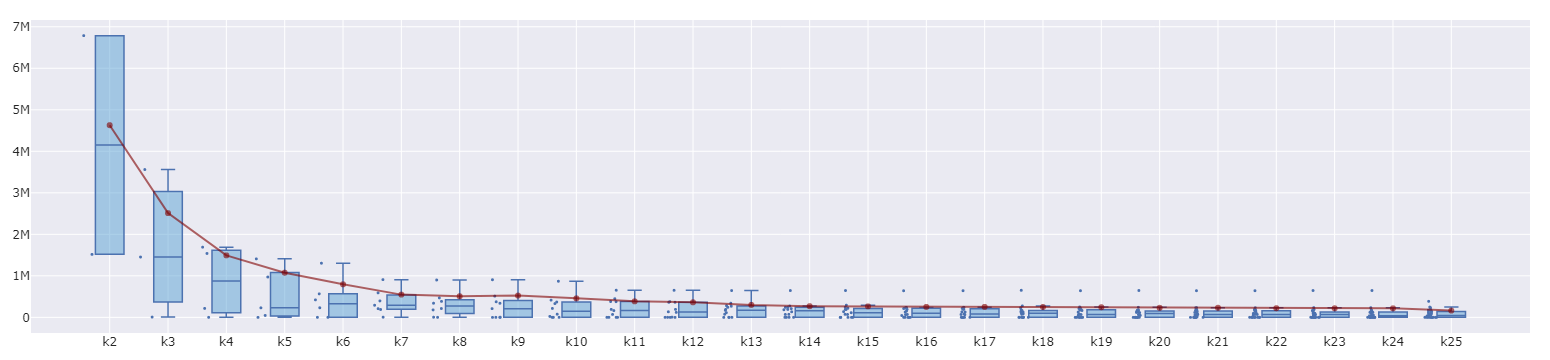

In [19]:
plot_elbow(DTW_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

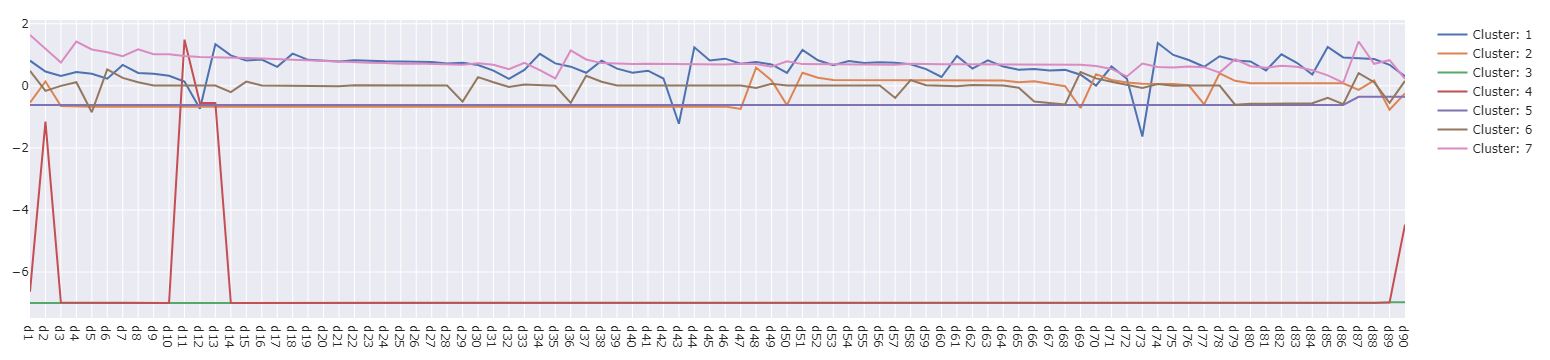

In [41]:
plot_centers(DTW_centres, alg='KUMAP', k = 'k7')

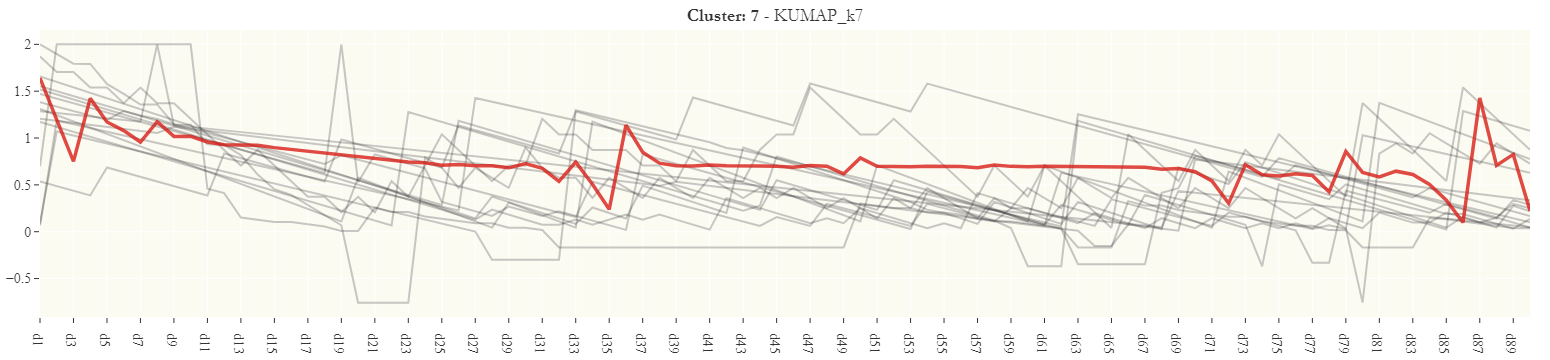

In [42]:
plot_cluster_samples(DTW_centres, df_data, alg = 'KUMAP', k = 'k7', cluster=7, sample=15, seed=42)

## *kMedoid*

In [51]:
DTAI_kMedoids_centres.iloc[:,:12].tail(9)

Algorithm    k  cluster  Cluster_Size  Total_Score     Sum_p99  \
639     KUMAP  k25       17           100   224.510528  220.330094   
640     KUMAP  k25       18           100   206.943607  202.658851   
641     KUMAP  k25       19           100    23.646481   15.939132   
642     KUMAP  k25       20           100   237.162544  232.936112   
643     KUMAP  k25       21           100     0.111257    0.015037   
644     KUMAP  k25       22           100    67.481245   59.706871   
645     KUMAP  k25       23           100    24.306128   16.699213   
646     KUMAP  k25       24           100     1.632753    1.483552   
647     KUMAP  k25       25           100   221.903199  217.985551   

        Sum_p95       QCD       p99       p95    Median      Mean  
639  204.100104  0.263669  4.172664  3.814701  2.180529  2.245105  
640  187.854911  0.237256  3.881426  3.542477  2.077901  2.069436  
641    6.121435       NaN  7.694803  0.651689  0.000000  0.236465  
642  216.796251  0.260946  4.084533  3.942797  2.315343  2.371625  
643    0.000000       NaN  0.015849  0.000000  0.000000  0.001113  
644   41.488050  0.000000  7.567901  1.392093  0.363865  0.674812  
645    5.322072  0.000000  7.372688  0.566496  0.042917  0.243061  
646    1.101109  0.630429  0.105903  0.062776  0.010367  0.016328  
647  204.638716  0.193795  3.613823  3.167280  2.341641  2.219032

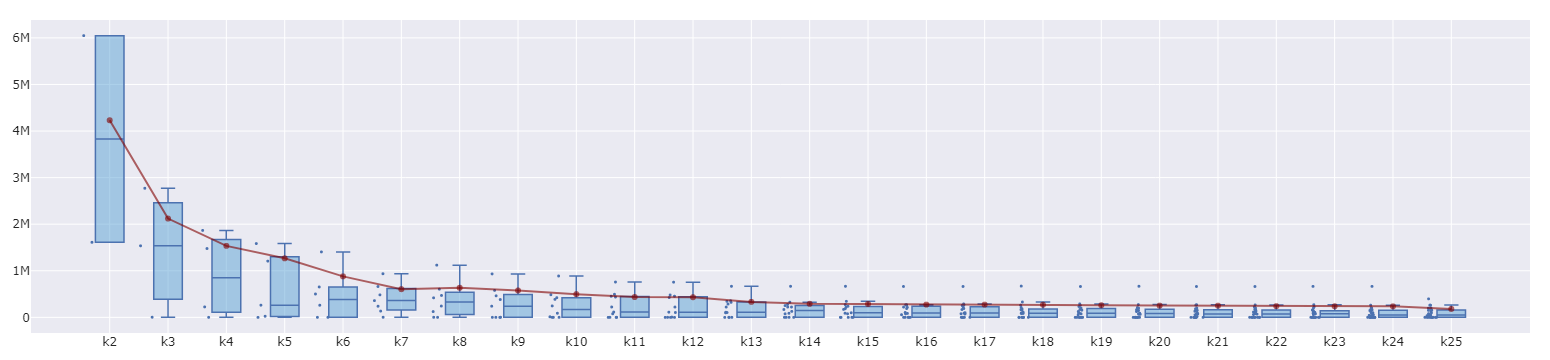

In [23]:
plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

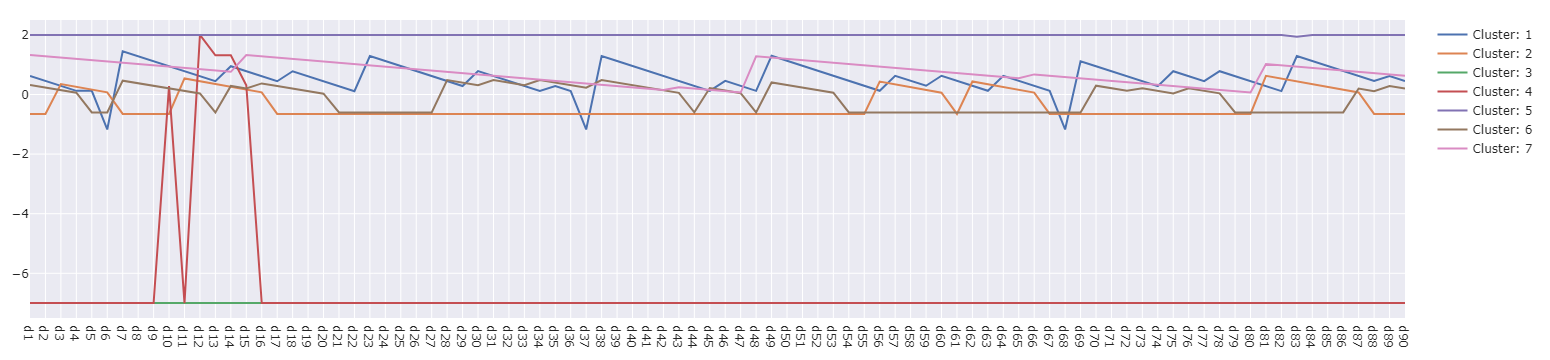

In [43]:
plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k7')

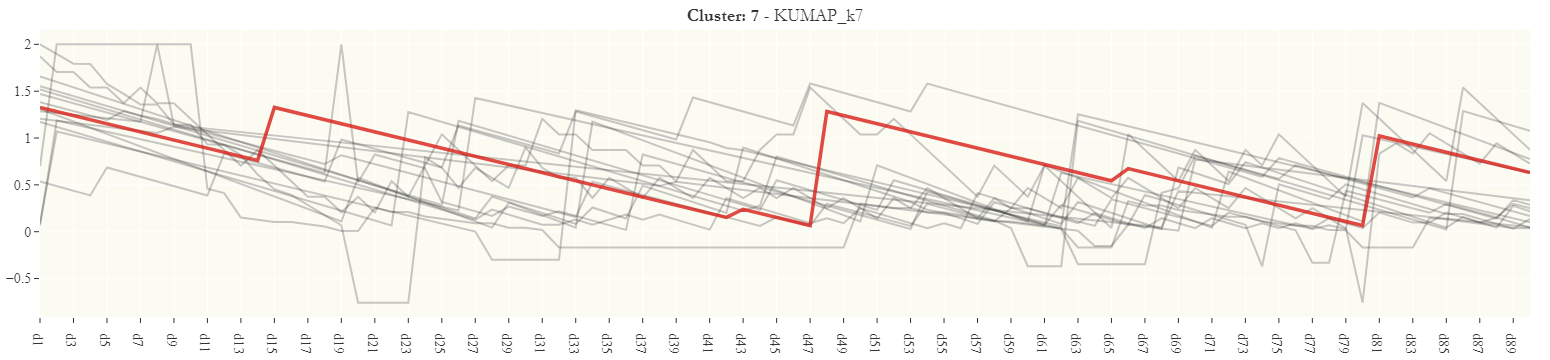

In [44]:
plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k7', cluster=7, sample=15, seed=42)

---
# kMedoids  - DTW
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.clustering.k_medoids.TimeSeriesKMedoids.html#sktime.clustering.k_medoids.TimeSeriesKMedoids.fit_predict

In [26]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in enumerate(sol_cols):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in range(c_min, c_max + 1):
#         i += 1
#         print(f'Processing {sol} ({i}/{total_c})', end='\r')
#         # print(f'\n{process}', end='\r')
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols][:100].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre
#         kMedoids = TimeSeriesKMedoids(n_clusters = 1, metric = 'dtw', max_iter = 10, tol = 0.001)
#         kMedoids_model = kMedoids.fit(sol_data)
#         centroid = kMedoids_model.cluster_centers_.ravel()
#         # Saving cluster centre
#         centroids.append(centroid)
        
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
        
        
# kMedoids_centres = pd.DataFrame(centroids, columns=window_cols)
# kMedoids_centres.insert(0, "cluster", clusters)
# kMedoids_centres.insert(0, "k", k)
# kMedoids_centres.insert(0, "Algorithm", algorithms)
# kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# kMedoids_centres.insert(3, "Total_Score", total_scores)
# kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [27]:
# kMedoids_centres.head(9)

In [28]:
# plot_elbow(kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [29]:
# plot_centers(kMedoids_centres, alg='KUMAP', k = 'k10')

---
# DTAI "kMedoids"  - DTW


In [30]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# dtai_kmedoids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
#         i += 1
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre (DTW)
#         centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
#         # Saving cluster centre
#         centroids.append(centroid)
       
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating cluster centre (kMedoid)
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         idx_min = np.argmin(np.abs(scores))
#         dtai_kmedoid = sol_data[idx_min]
#         dtai_kmedoids.append(dtai_kmedoid)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(dtai_kmedoid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
      
        
# DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
# DTAI_kMedoids_centres.insert(0, "cluster", clusters)
# DTAI_kMedoids_centres.insert(0, "k", k)
# DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
# DTAI_kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# DTAI_kMedoids_centres.insert(3, "Total_Score", total_scores)
# DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [31]:
# DTAI_kMedoids_centres.head(9)

In [32]:
# plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [33]:
# plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k11')

In [34]:
# plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k11', cluster=1, sample=10, seed=None)

---
# Saving Results

## Euclidean

In [35]:
solution_fileName = f'{solution_name}-Euc_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-Euc_Centers.csv'

In [36]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
Euclidean_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## DTW

In [37]:
solution_fileName = f'{solution_name}-DTW_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-DTW_Centers.csv'

In [38]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTW_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## kMedoid(DTW)

In [39]:
solution_fileName = f'{solution_name}-kMedoid_DTW_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-kMedoid_DTW_Centers.csv'

In [40]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTAI_kMedoids_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)